In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


a = np.array([0,2])
b = np.array([1,2])


a.tolist()

[0, 2]

In [43]:
class Test:
    def __init__(self):
        pass

    def is_in_range(self, angle, range):
        if range[0] <= angle and angle <= range[1]:
            return True
        else:
            return False
        
    def generate_sector_angle_list(self):
        
        angle_gate = np.deg2rad(32)
        angle_none = np.deg2rad(60) - angle_gate

        angle_start = -np.pi - angle_gate/2

        ang = angle_start + angle_gate + angle_none

        gate_angle_list = []

        for i in range(5):
            angle_rangle = [ang, ang + angle_gate]
            gate_angle_list.append(angle_rangle)
            ang += angle_gate + angle_none
        
        self.gate_angle_list = gate_angle_list   
    
    def get_sector(self, angle):
        i = 0
        for range in self.gate_angle_list:
            if self.is_in_range(angle, range):
                return i
            i += 1
        return None


Test = Test()
Test.generate_sector_angle_list()

Test.gate_angle_list
Test.get_sector(np.deg2rad(-136)), Test.get_sector(np.deg2rad(-104)), -180+16+28
    

(0, None, -136)

In [44]:
start = -136

for i in range(5):
    print(start, start + 32)
    start += 60

-136 -104
-76 -44
-16 16
44 76
104 136


In [ ]:
[2.12, 1.84, 1.24]
[5.12, 2.30, 0.78]
[7.20, 3.27, 1.29]
[5.30, 6.74, 1.19]
[2.52, 5.50, 1.04]

[4.00, 4.00, 0.00]

In [12]:
# 回调函数测试

# 定义回调函数（业务逻辑）
def my_callback(result):
    print("接收到的数据是：", result)

# 定义一个接收回调函数的“主”函数
def fetch_data(callback):
    # 模拟获取数据的过程
    data = {"user": "Alice", "score": 95}
    # 数据准备好后，调用回调函数
    callback(data)

# 将回调函数传进去
fetch_data(my_callback)


接收到的数据是： {'user': 'Alice', 'score': 95}


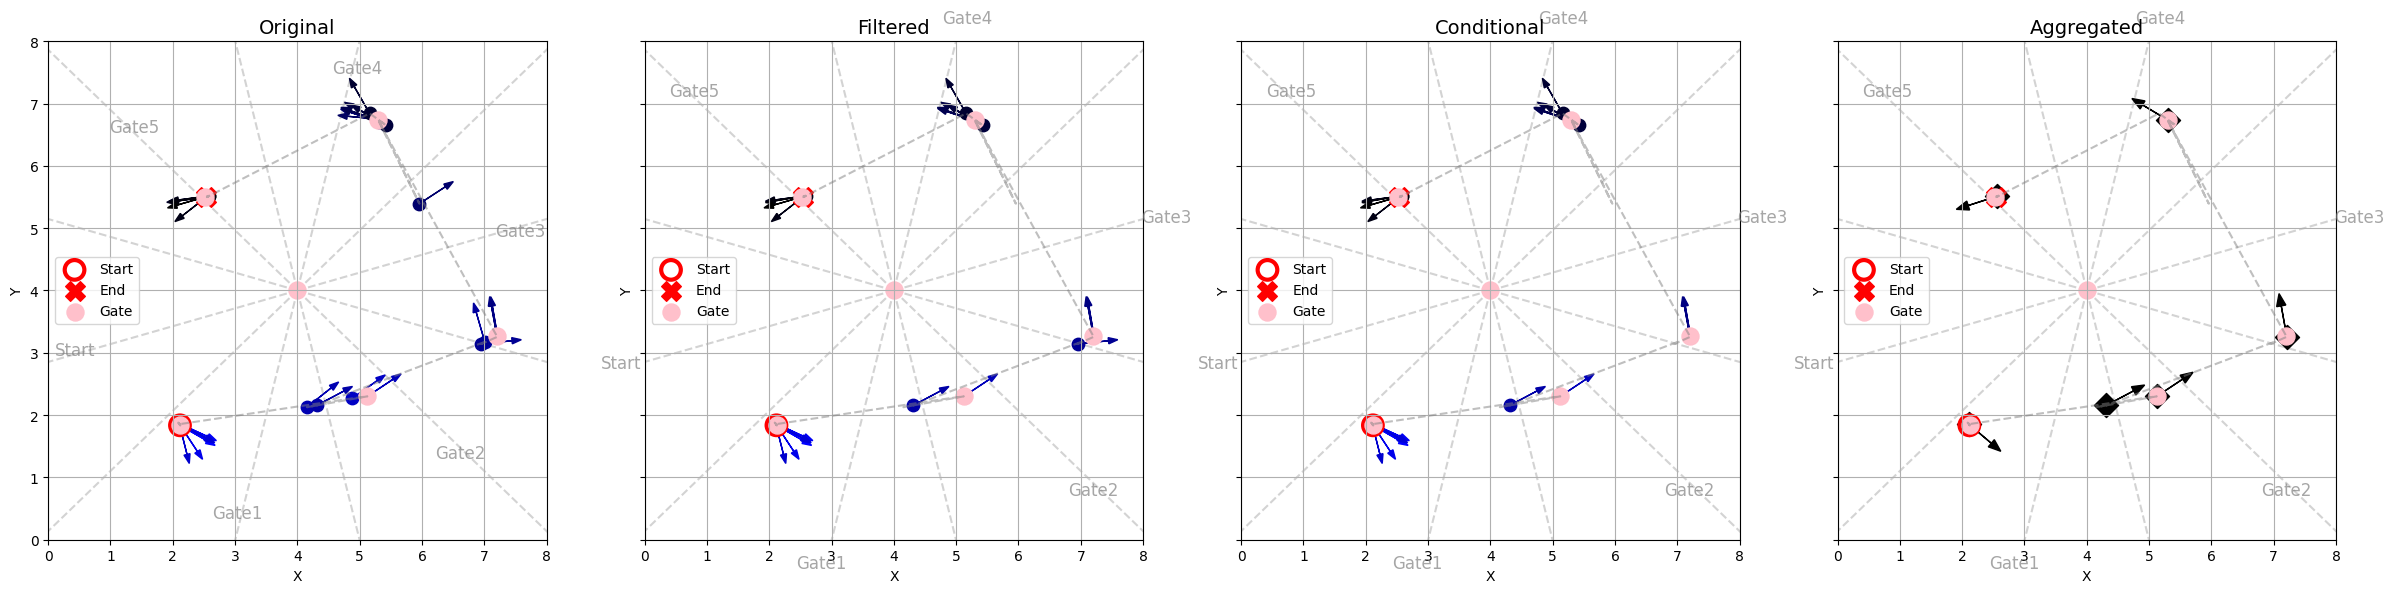

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取并筛选 P0, P3, P4
df = pd.read_csv('target_positions.csv')
df_p0 = df[df['point_index'] == 0].set_index('frame').sort_index()
df_p3 = df[df['point_index'] == 3].set_index('frame').sort_index()
df_p4 = df[df['point_index'] == 4].set_index('frame').sort_index()
frames      = df_p4.index.values
points4     = df_p4[['x','y']].values
num_points  = len(frames)

# 2. 距离阈值
T = 0.5

# 3. mask
mask = np.zeros(num_points, dtype=bool)
mask[0] = True
for i in range(1, num_points):
    if np.hypot(*(points4[i] - points4[i-1])) < T:
        mask[i] = True

# 4. 颜色渐变
colors_all      = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]
colors_filtered = [colors_all[i] for i in range(num_points) if mask[i]]

# Gate 点（示例）
pink_points = np.array([
    [2.12, 1.84],
    [5.12, 2.30],
    [7.20, 3.27],
    [5.30, 6.74],
    [2.52, 5.50],
    [4.00, 4.00]
])

# 5. 计算 Cond & 聚类（同你原来逻辑）
cond_idxs = []
for i in range(num_points):
    if not mask[i]:
        continue
    v1 = points4[i] - np.array([4., 4.])
    fr = frames[i]
    x0, y0 = df_p0.loc[fr, ['x','y']]
    x3, y3 = df_p3.loc[fr, ['x','y']]
    theta   = np.arctan2(y0-y3, x0-x3) - np.pi/2
    v2      = np.array([np.cos(theta), np.sin(theta)])
    cos_ang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-8)
    ang_deg = np.degrees(np.arccos(np.clip(cos_ang, -1, 1)))
    v1_3 = np.array([v1[0], v1[1], 0.])
    v2_3 = np.array([v2[0], v2[1], 0.])
    if 45 <= ang_deg <= 135 and np.cross(v1_3, v2_3)[2] > 0:
        cond_idxs.append(i)

clusters = []
if cond_idxs:
    current = [cond_idxs[0]]
    for prev, curr in zip(cond_idxs, cond_idxs[1:]):
        if np.hypot(*(points4[curr] - points4[prev])) < 0.8:
            current.append(curr)
        else:
            clusters.append(current)
            current = [curr]
    clusters.append(current)

# 6. 画 1×4 子图，并在每个 ax 上绘制扇区
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
titles = ['Original', 'Filtered', 'Conditional', 'Aggregated']
L = 0.5  # 箭头长度
center = np.array([4.0, 4.0])  # 扇区中心

for ax, title in zip(axes, titles):
    # 背景轨迹
    ax.plot(df_p4['x'], df_p4['y'],
            ls='--', color='gray', alpha=0.5)

    # 按子图类型画点/箭头或聚类
    if title == 'Original':
        idxs, cs = range(num_points), colors_all
    elif title == 'Filtered':
        idxs, cs = [i for i in range(num_points) if mask[i]], colors_filtered
    elif title == 'Conditional':
        idxs, cs = cond_idxs, [colors_all[i] for i in cond_idxs]
    else:  # Aggregated
        # 聚类中心 & 箭头
        for clust in clusters:
            pts = points4[clust]
            xm, ym = pts.mean(axis=0)
            dxy = []
            for i in clust:
                fr = frames[i]
                x0, y0 = df_p0.loc[fr, ['x','y']]
                x3, y3 = df_p3.loc[fr, ['x','y']]
                th = np.arctan2(y0-y3, x0-x3) - np.pi/2
                dxy.append([L*np.cos(th), L*np.sin(th)])
            dx, dy = np.array(dxy).mean(axis=0)
            ax.scatter(xm, ym, s=150, marker='D', c='k')
            ax.arrow(xm, ym, dx, dy,
                     head_width=0.15, head_length=0.2,
                     fc='k', ec='k')
        idxs, cs = [], []

    # 画单点和箭头
    for k, i in enumerate(idxs):
        x4, y4 = points4[i]
        ax.scatter(x4, y4, c=[cs[k]], s=80)
        fr = frames[i]
        x0, y0 = df_p0.loc[fr, ['x','y']]
        x3, y3 = df_p3.loc[fr, ['x','y']]
        th = np.arctan2(y0-y3, x0-x3) - np.pi/2
        dx, dy = L*np.cos(th), L*np.sin(th)
        ax.arrow(x4, y4, dx, dy,
                 head_width=0.1, head_length=0.15,
                 fc=cs[k], ec=cs[k])

    # 起点/终点/Gate
    ax.scatter(*points4[0], s=200, facecolors='none',
               edgecolors='red', marker='o', lw=3, label='Start')
    ax.scatter(*points4[-1], s=200, c='red', marker='X', label='End')
    ax.scatter(pink_points[:,0], pink_points[:,1],
               c='pink', marker='o', s=150, label='Gate')

    # —— 新增：扇区线 —— #
    # 先拿到当前子图的范围，算一个足够大的半径
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    r = np.hypot(x1-x0, y1-y0)

    angle_gate = 32/180 * np.pi          # 32°
    angle_none = np.pi / 3 - angle_gate  # 
    start_ang  = np.pi - angle_gate / 2  

    ang = start_ang
    # 每 30° 一条线
    for k in range(6):
        
        xe = center[0] + r * np.cos(ang)
        ye = center[1] + r * np.sin(ang)
        ax.plot([center[0], xe], [center[1], ye],
                ls='--', c='lightgray', zorder=0)
        
        ang = ang + angle_gate
        xe = center[0] + r * np.cos(ang)
        ye = center[1] + r * np.sin(ang)
        ax.plot([center[0], xe], [center[1], ye],
                ls='--', c='lightgray', zorder=0)

        ang = ang + angle_none
        
    # —— 新增：扇区标签 —— #
    sector_labels = {
        0: "Start",
        2: "Gate1",
        4: "Gate2",
        6: "Gate3",
        8: "Gate4",
        10: "Gate5"
    }
    for k, lbl in sector_labels.items():
        mid_ang = np.pi + (k + 0.5) * np.pi/6
        xt = center[0] + r*0.4 * np.cos(mid_ang)
        yt = center[1] + r*0.4 * np.sin(mid_ang)
        ax.text(xt, yt, lbl,
                ha='center', va='center',
                fontsize=12, color='gray', alpha=0.7)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


(2.106, 1.854, 1.266)
(5.122, 2.301, 0.801)
(4.31, 2.155, 0.89)
(7.121, 3.22, 1.297)
(5.309, 6.729, 1.211)
(2.562, 5.513, 1.069)


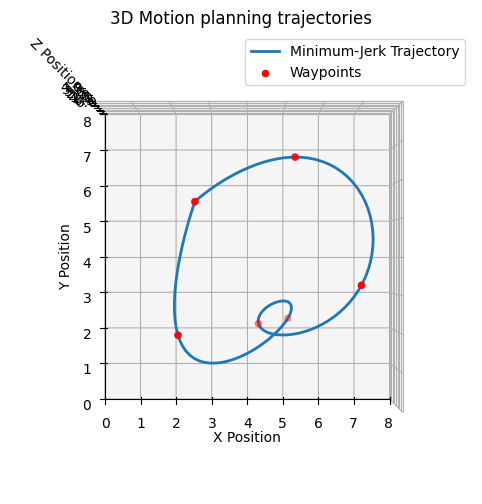

Maximum flight speed: 3.4683687892260155
Average flight speed: 2.0452717904526048
Average flight acceleration: 3.0081341607728884
Maximum flight acceleration: 5.166490833766701


array([[2.562     , 5.513     , 1.069     , 0.        ],
       [2.56158632, 5.51187128, 1.06909086, 0.        ],
       [2.55888668, 5.5043795 , 1.06968913, 0.        ],
       [2.55213544, 5.48525262, 1.07120179, 0.        ],
       [2.54009579, 5.45033915, 1.07393314, 0.        ],
       [2.52201719, 5.39653154, 1.07809237, 0.        ],
       [2.4975928 , 5.32168951, 1.08380116, 0.        ],
       [2.46691686, 5.22456349, 1.09110121, 0.        ],
       [2.43044212, 5.10471794, 1.09996184, 0.        ],
       [2.38893724, 4.96245476, 1.11028756, 0.        ],
       [2.34344419, 4.79873666, 1.12192562, 0.        ],
       [2.2952357 , 4.61511052, 1.13467362, 0.        ],
       [2.24577262, 4.4136308 , 1.14828707, 0.        ],
       [2.19666137, 4.19678288, 1.16248692, 0.        ],
       [2.14961131, 3.96740646, 1.1769672 , 0.        ],
       [2.10639221, 3.72861891, 1.19140254, 0.        ],
       [2.06879158, 3.48373869, 1.20545578, 0.        ],
       [2.03857215, 3.2362087 ,

In [ ]:
from controllers.main.assignment.filter import *

data = AggregatedExtractor(csv_path='target_positions.csv')
data.get_aggregated()
points = data.convert_to_planning()

for point in points:
    print(point)

from controllers.main.assignment.planning import *
planner = MotionPlanner3D(obstacles=None, points=points, DEBUG = True)
planner.trajectory_setpoints

In [6]:
def set_axes_equal(ax):
    '''
    为了 3D 图等比例显示，手动把 x,y,z 的 lim 调成相同范围
    '''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]

    max_range = max(x_range, y_range, z_range)

    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)

    ax.set_xlim3d(x_mid - max_range/2, x_mid + max_range/2)
    ax.set_ylim3d(y_mid - max_range/2, y_mid + max_range/2)
    ax.set_zlim3d(z_mid - max_range/2, z_mid + max_range/2)


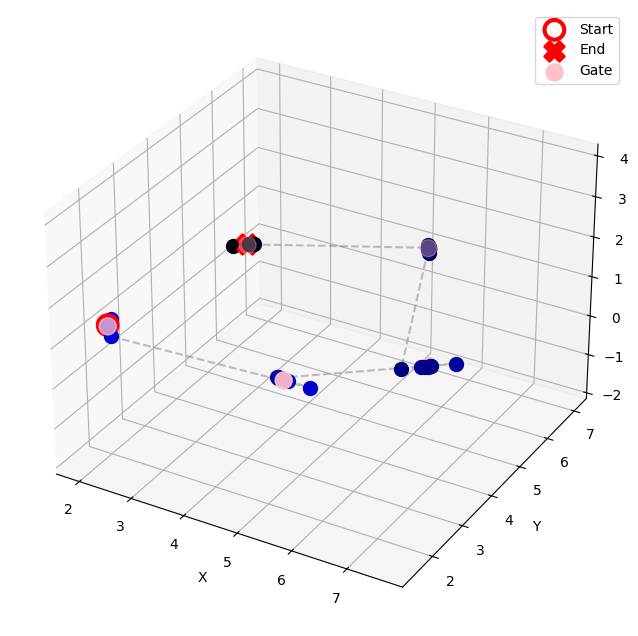

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 绘图模块

# 读取 CSV 文件
df = pd.read_csv('target_positions.csv')

# 筛选 point_index 为 4 的数据，并按 frame 排序
df_center = df[df['point_index'] == 4].sort_values('frame').reset_index(drop=True)
num_points = len(df_center)

# 构造颜色列表：颜色从蓝色到黑色（RGB: (0,0,1) 到 (0,0,0)）
colors = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]

# 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制连线表示轨迹（灰色虚线）
ax.plot(df_center['x'], df_center['y'], df_center['z'], linestyle='--', color='gray', alpha=0.5)

# 绘制所有点（采样点），使用渐变颜色
for idx, row in df_center.iterrows():
    color = colors[idx]
    ax.scatter(row['x'], row['y'], row['z'], color=color, s=100)

# 标注起点（第一个点，用红色圆圈标注）
start = df_center.iloc[0]
ax.scatter(start['x'], start['y'], start['z'], s=200, facecolors='none',
           edgecolors='red', marker='o', linewidths=3, label='Start')

# 标注终点（最后一个点，用红色叉号标注）
end = df_center.iloc[-1]
ax.scatter(end['x'], end['y'], end['z'], s=200, color='red', marker='X', linewidths=2, label='End')

# 用粉色标注预设的五个点
# 给定的五个点（X, Y, Z 坐标）
pink_points = np.array([
    [2.12, 1.84, 1.24],
    [5.12, 2.30, 0.78],
    [7.20, 3.27, 1.29],
    [5.30, 6.74, 1.19],
    [2.52, 5.50, 1.04]
])
# 绘制粉色点，并加上标签
ax.scatter(pink_points[:, 0], pink_points[:, 1], pink_points[:, 2], 
           color='pink', marker='o', s=150, label='Gate')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

set_axes_equal(ax)


ax.legend()
plt.show()


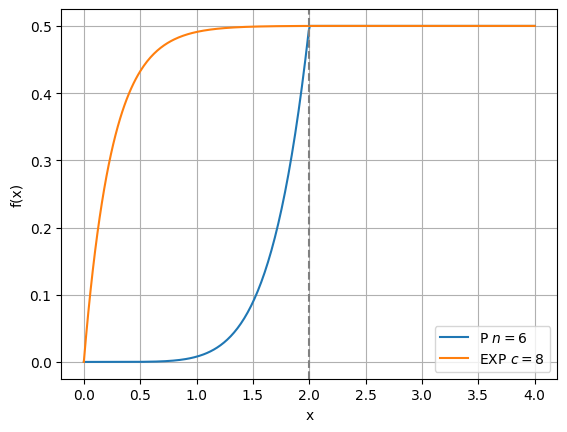

In [8]:
import numpy as np

def f_poly(x, T, n=4):
    """
    多项式型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5*(x/T)^n
      x<0     -> 0
    n 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    f[mask2] = 0.5 * (x[mask2] / T)**n
    return f

import numpy as np

def f_exp(x, T, c=5):
    """
    指数型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5 * (1 - exp(-c*(x/T))) / (1 - exp(-c))
      x<0     -> 0
    c 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    denom = 1 - np.exp(-c)
    f[mask2] = 0.5 * (1 - np.exp(-c * (x[mask2] / T))) / denom
    return f

import matplotlib.pyplot as plt

T = 2.0
xs = np.linspace(0, 4, 400)

plt.plot(xs, f_poly(xs, T, n=6),  label='P $n=6$')
plt.plot(xs, f_exp(xs, T, c=8),   label='EXP $c=8$')
plt.axvline(T, color='gray', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


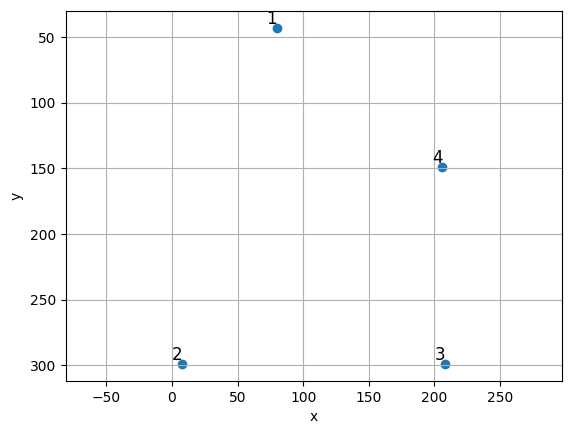

In [9]:
import numpy as np

def sort_quad_points(pts):
    """
    输入：
        pts: numpy 数组，形状 (4,2)，每行是一个 (x,y) 坐标
    返回：
        按 [左上, 左下, 右下, 右上] 排序后的点，形状 (4,2)
    """
    # 1. 按 x 坐标升序，分成左右两组
    pts_sorted = pts[np.argsort(pts[:, 0])]
    left  = pts_sorted[:2]   # x 最小的两个
    right = pts_sorted[2:]   # x 最大的两个

    # 2. 左组按 y 升序：上<下；右组同理
    left  = left[np.argsort(left[:, 1])]
    right = right[np.argsort(right[:, 1])]

    tl, bl = left    # top-left, bottom-left
    tr, br = right   # top-right, bottom-right

    return np.array([tl, bl, br, tr], dtype=pts.dtype)

def plot_quad_points(pts, sorted_pts=None):
    """
    输入：
        pts: 原始点数组，形状 (4,2)
        sorted_pts: 已排序点（可选），若不传则内部调用 sort_quad_points
    """
    if sorted_pts is None:
        sorted_pts = sort_quad_points(pts)
    
    plt.figure()
    plt.scatter(sorted_pts[:, 0], sorted_pts[:, 1])
    for i, (x, y) in enumerate(sorted_pts, start=1):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
    plt.gca().invert_yaxis()  # 图像坐标系
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.title('排序后四边形顶点及序号')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# 使用示例
pts = np.array([[80, 43],
                [8, 299],
                [208, 299],
                [206, 149]])
plot_quad_points(pts)


In [10]:
a = np.nan

a == np.nan

False